In [1]:
# google colab の場合は、この下のコメントアウトを外す
# ! pip install statsmodels==0.13.1

In [2]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels
import pmdarima
import sklearn

DataFrame.shape: (309, 2)
     YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0
       YEAR  SUNACTIVITY
306  2006.0         15.2
307  2007.0          7.5
308  2008.0          2.9


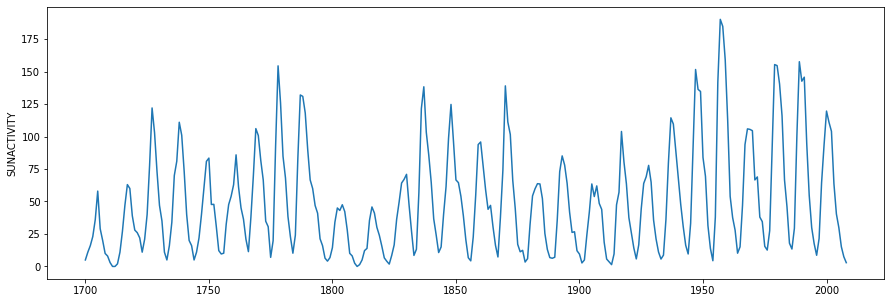

In [11]:
# statsmodelsライブラリのサンプルデータ・太陽黒点数のデータフレームを作成
sunspot_df = statsmodels.api.datasets.sunspots.load_pandas().data
print('DataFrame.shape:', sunspot_df.shape) # データフレームの形状を表示
print(sunspot_df.head(3))  # 先頭3行を表示
print(sunspot_df.tail(3))  # 先頭3行を表示
fig, ax = plt.subplots(1, 1, figsize=(15,5)) # 折れ線グラフで表示
ax.set_ylabel('SUNACTIVITY')
g = ax.plot(sunspot_df.YEAR, sunspot_df.SUNACTIVITY)

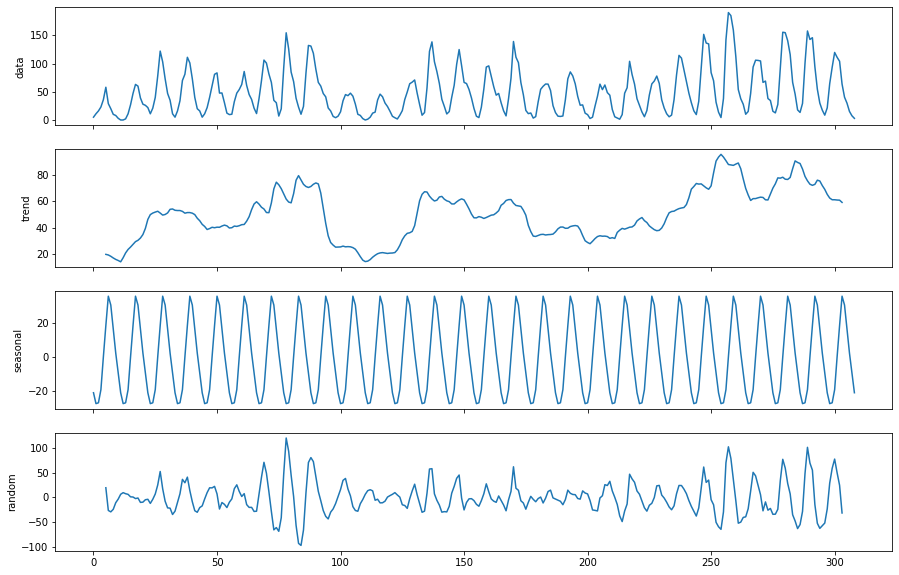

In [4]:
# 時系列データの成分分解（data -> tread, seasonal, random）
data = sunspot_df.SUNACTIVITY.values
pmdarima.utils.decomposed_plot(pmdarima.arima.decompose(data,'additive',m=11),
                               figure_kwargs = {'figsize': (15, 10)} )

       YEAR  SUNACTIVITY
288  1988.0        100.2
289  1989.0        157.6
       YEAR  SUNACTIVITY
290  1990.0        142.6
291  1991.0        145.7


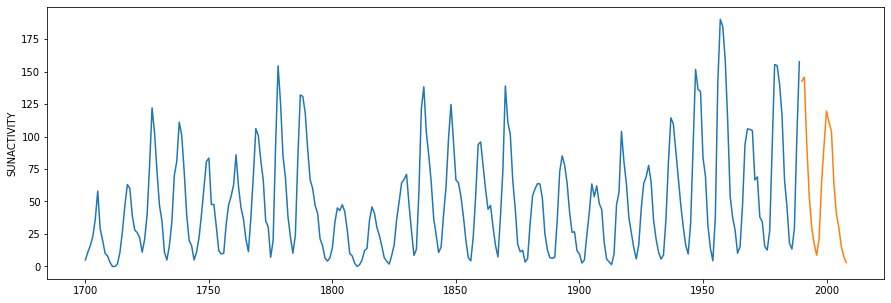

In [5]:
# 時系列モデルの学習と性能検証のため、データを学習用(先頭から270件)と検証用(271件目以降)に分割
train_data = sunspot_df[:290]
print(train_data.tail(2))
test_data = sunspot_df[290:]
print(test_data.head(2))
fig, ax = plt.subplots(1, 1, figsize=(15,5)) # 折れ線グラフで表示
ax.set_ylabel('SUNACTIVITY')
g = ax.plot(train_data.YEAR, train_data.SUNACTIVITY)
g = ax.plot(test_data.YEAR, test_data.SUNACTIVITY)

In [6]:
# 単位根検定 -> 先頭から、検定値、P値 の順で出力される (P値が 0.05より大きい場合、単位根AR(p)過程でないとはいえない)
print(statsmodels.tsa.stattools.adfuller(train_data.SUNACTIVITY.values))

(-2.2754228072247895, 0.18001715068971225, 8, 281, {'1%': -3.4538376962008495, '5%': -2.8718811911083093, '10%': -2.5722803076202174}, 2275.4920491692833)


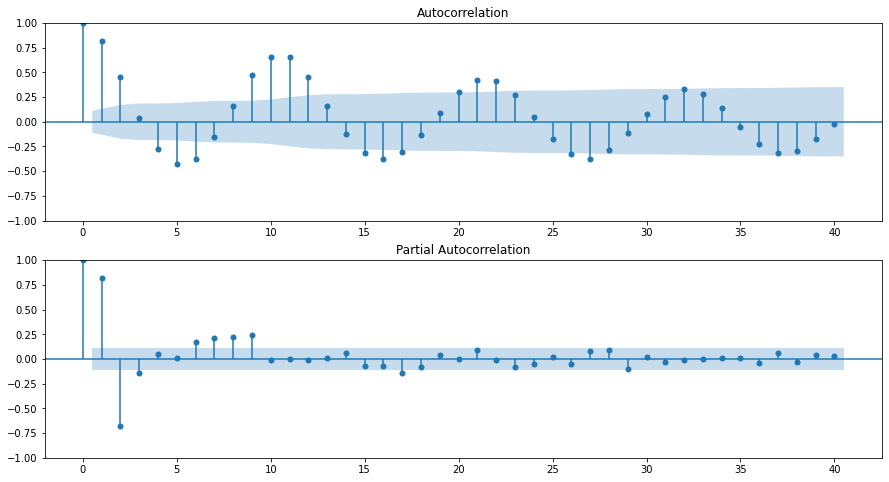

In [7]:
# コレログラム（自己相関と偏自己相関）を表示
data = sunspot_df.SUNACTIVITY.values
fig, ax = plt.subplots(2, 1, figsize=(15,8))
fig = statsmodels.api.graphics.tsa.plot_acf(data, lags=40, ax=ax[0])
fig = statsmodels.api.graphics.tsa.plot_pacf(data, lags=40, ax=ax[1], method='ywm')

train_data MAE: 15.38201241082407
train_data MAE: 481.9418988207372
test_data MAE: 51.61632198224773
test_data MAE: 3625.6126603640428


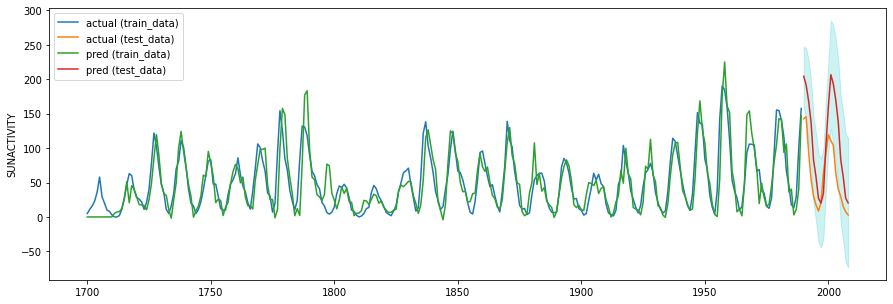

In [8]:
# モデル(次数は仮設定)を作成し、学習データで学習
sarima_model = statsmodels.tsa.statespace.sarimax.SARIMAX(train_data.SUNACTIVITY.values, 
                                                          order=(1, 0, 0), seasonal_order=(0, 1, 0, 11))
sarima_fit = sarima_model.fit()

##学習データの期間の予測値と、その平均絶対誤差(MAE)と平均二乗誤差(MSE)
train_pred = sarima_fit.predict()
print('train_data MAE:', 
      sklearn.metrics.mean_absolute_error(train_data.SUNACTIVITY.values, train_pred))
print('train_data MAE:', 
      sklearn.metrics.mean_squared_error(train_data.SUNACTIVITY.values, train_pred))
##テストデータの期間の予測値と予測区間(95%信頼区間)と、その平均絶対誤差(MAE)と平均二乗誤差(MSE)
test_pred = sarima_fit.get_forecast(len(test_data))
print('test_data MAE:', 
      sklearn.metrics.mean_absolute_error(test_data.SUNACTIVITY.values, test_pred.predicted_mean))
print('test_data MAE:', 
      sklearn.metrics.mean_squared_error(test_data.SUNACTIVITY.values, test_pred.predicted_mean))

# 結果をグラフで表示
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.set_ylabel('SUNACTIVITY')
g = ax.plot(train_data.YEAR, train_data.SUNACTIVITY, label="actual (train_data)")
g = ax.plot(test_data.YEAR, test_data.SUNACTIVITY, label="actual (test_data)")
g = ax.plot(train_data.YEAR, train_pred, label="pred (train_data)")
g = ax.plot(test_data.YEAR, test_pred.predicted_mean, label="pred (test_data)")
ax.fill_between(test_data.YEAR, test_pred.conf_int()[:, 0], test_pred.conf_int()[:, 1], color='c', alpha=.2)
g = ax.legend()

 ARIMA(5,1,2)(0,0,0)[11]          
train_data MAE: 11.2368224355071
train_data MSE: 228.07959779608862
test_data MAE: 34.53698136433083
test_data MSE: 1392.368084537681


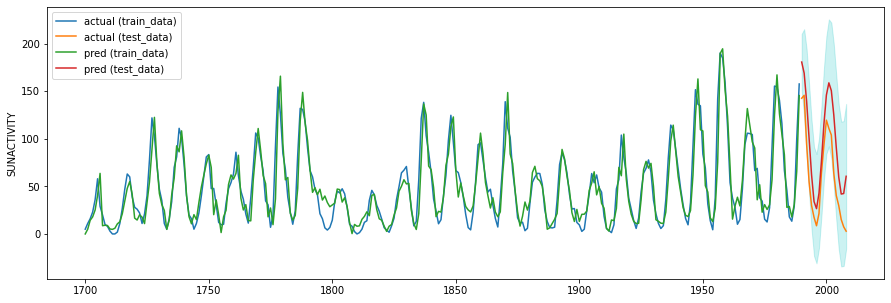

In [9]:
# 次数探索を行い、最適次数でモデルを作成し、学習データで学習
auto_model = pmdarima.auto_arima(train_data.SUNACTIVITY.values, seasonal=True, m=11)
print(auto_model)

##学習データの期間の予測値と、その平均絶対誤差(MAE)と平均二乗誤差(MSE)
train_pred = auto_model.predict_in_sample()
print('train_data MAE:', 
      sklearn.metrics.mean_absolute_error(train_data.SUNACTIVITY.values, train_pred))
print('train_data MSE:', 
      sklearn.metrics.mean_squared_error(train_data.SUNACTIVITY.values, train_pred))
##テストデータの期間の予測値と予測区間(95%信頼区間)と、その平均絶対誤差(MAE)と平均二乗誤差(MSE)
test_pred, test_pred_ci = auto_model.predict(n_periods=test_data.shape[0], return_conf_int=True)
print('test_data MAE:', 
      sklearn.metrics.mean_absolute_error(test_data.SUNACTIVITY.values, test_pred))
print('test_data MSE:', 
      sklearn.metrics.mean_squared_error(test_data.SUNACTIVITY.values, test_pred))

# 結果をグラフで表示
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.set_ylabel('SUNACTIVITY')
g = ax.plot(train_data.YEAR, train_data.SUNACTIVITY, label="actual (train_data)")
g = ax.plot(test_data.YEAR, test_data.SUNACTIVITY, label="actual (test_data)")
g = ax.plot(train_data.YEAR, train_pred, label="pred (train_data)")
g = ax.plot(test_data.YEAR, test_pred, label="pred (test_data)")
ax.fill_between(test_data.YEAR, test_pred_ci[:, 0], test_pred_ci[:, 1], color='c', alpha=.2)
g = ax.legend()